In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, fbeta_score
from sklearn.metrics import plot_confusion_matrix
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/simran.tyagi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#!pip install ftfy
#!pip install scrubadub
#!pip install demoji
#!pip install tabulate
#!pip install wordcloud
#pip install xgboost

In [3]:
def read_file():
    df = pd.read_csv('/home/simran.tyagi/Downloads/panasonic_v1_f.csv')
    df = df[['text', 'Complaint']]
    return df


In [4]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import re
import ftfy
import scrubadub
# import string
from tabulate import tabulate
import demoji
# import emoji
from nltk.corpus import stopwords


stop = stopwords.words('english')
emailDetector = scrubadub.Scrubber(detector_list=[scrubadub.detectors.EmailDetector])
wnl = WordNetLemmatizer()

label_codes = {'No': 0, 'Yes': 1}
t_handle_regex = r'(^|[^@\w])@(\w{1,15})\b'
t_hashtag_regex = r"#(\w+)"
t_url_regex = r"https?://\S+|www\.\S+"
t_markup_regex = r"<(\"[^\"]*\"|'[^']*'|[^'\">])*>"
t_handle_placeholder = ' {{HANDLE}}'
t_hashtag_placeholder = ' {{HASHTAG}}'
t_url_placeholder = '{{URL}}'
t_markup_placeholder = '{{MARKUP}}'
emoji_placeholder = '{{EMOJI}}'
# domain specific stopwords.
stop.extend(['panasonic'])

# table = str.maketrans("", "")


def penn_to_wn(tag):
    def is_noun(tag):
        return tag in ['NN', 'NNS', 'NNP', 'NNPS']

    def is_verb(tag):
        return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

    def is_adverb(tag):
        return tag in ['RB', 'RBR', 'RBS']

    def is_adjective(tag):
        return tag in ['JJ', 'JJR', 'JJS']

    # Pos tags to wn tags
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

def to_lower_case(text):
    return text.lower()

def fix_unicode(text):
    return ftfy.fix_text(text)

def replace_email(text):
    return emailDetector.clean(text)

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

def convert_emoji_to_text(text):
    return text

def replace_user_name(text):
    return re.sub(t_handle_regex, t_handle_placeholder, text)

def replace_hashtags(text):
    return re.sub(t_hashtag_regex, t_hashtag_placeholder,text)

def replace_url(text):
    return re.sub(t_url_regex, t_url_placeholder, text)

def replace_markup(text):
    return re.sub(t_markup_regex, t_markup_placeholder,text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

def replace_emoji_with_code(text):
    demoji.replace(text, repl=emoji_placeholder)
    return demoji.replace_with_desc(text)

def get_stats(step, df):
    corpus = " ".join(list(df['text']))
    total_words = len(corpus.split(' '))
    unique_words = len(set(corpus.split(' ')))
    return [step, total_words, unique_words]

def lemmatize(text):
    default_wn_tag = 'n'
    tokens = text.split(' ')
    pos_tags = nltk.pos_tag(tokens)
    wn_tags = [penn_to_wn(tag) for (w, tag) in pos_tags]
    # print(list(zip(pos_tags, wn_tags)))
    lemmas = [wnl.lemmatize(token, tag or default_wn_tag) for (token, tag) in list(zip(tokens, wn_tags))]
    return ' '.join(lemmas)

stats = [['Step', 'Total words', 'Unique words']]
df = read_file()
stats.append(get_stats('Start', df))
df = df.replace(label_codes)

df['text'] = df['text'].apply(lambda text: text.lower())
stats.append(get_stats('Lower', df))

df['text'] = df['text'].apply(lambda text: lemmatize(text))
stats.append(get_stats('Lemmatize', df))

df['text'] = df['text'].apply(fix_unicode)
stats.append(get_stats('Unicode Fix', df))

df['text'] = df['text'].apply(replace_emoji_with_code)
stats.append(get_stats('Replace emoji', df))

df['text'] = df['text'].apply(remove_stop_words)
stats.append(get_stats('Stop words', df))

df['text'] = df['text'].apply(replace_email)
stats.append(get_stats('Email Replace', df))

df['text'] = df['text'].apply(replace_user_name)
stats.append(get_stats('UserName replace', df))

df['text'] = df['text'].apply(replace_hashtags)
stats.append(get_stats('HashTags Replace', df))

df['text'] = df['text'].apply(replace_url)
stats.append(get_stats('URL Replace', df))

df['text'] = df['text'].apply(replace_markup)
stats.append(get_stats('MARKUP Replace', df))

df['text'] = df['text'].apply(remove_punctuations)
stats.append(get_stats('Remove punctuation', df))


print(tabulate(stats))


------------------  -----------  ------------
Step                Total words  Unique words
Start               77684        20298
Lower               77684        18224
Lemmatize           77684        17402
Unicode Fix         77691        17336
Replace emoji       78144        17451
Stop words          59345        16833
Email Replace       59345        16826
UserName replace    60034        15499
HashTags Replace    75185        11377
URL Replace         75185        9179
MARKUP Replace      75185        9178
Remove punctuation  75185        7210
------------------  -----------  ------------


In [5]:
tfidf = TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.01)  
tfidf_wm = tfidf.fit_transform(df['text']).toarray() 
x_train, x_test, y_train, y_test = train_test_split(tfidf_wm, df['Complaint'], random_state = 42) 


In [10]:
from sklearn.svm import SVC
svc_model = SVC(kernel = 'linear', C = 9,random_state= 42)
svc_model.fit(x_train, y_train)

SVC(C=9, kernel='linear', random_state=42)

In [11]:
pred_test_x = svc_model.predict(x_test)
print("Accuracy Score:",round(accuracy_score(y_test,pred_test_x),2))
print("Recall-Score:",round(recall_score(y_test,pred_test_x),3))
print("Precision-Score:",round(precision_score(y_test,pred_test_x),3))
print("F1-score:",round(f1_score(y_test,pred_test_x),3))
print("F2-Score:",round(fbeta_score(y_test,pred_test_x,beta = 2),3))

Accuracy Score: 0.95
Recall-Score: 0.807
Precision-Score: 0.838
F1-score: 0.822
F2-Score: 0.813


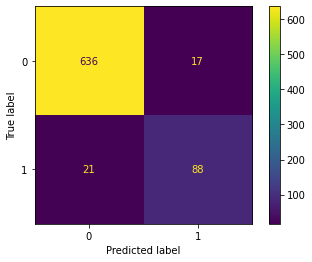

In [12]:
plot_confusion_matrix(svc_model, x_test, y_test)  